In [31]:
import yfinance as yf
import pandas as pd
from torch.utils.tensorboard import SummaryWriter
import os
from fiftyone.utils.ultralytics import torch
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [32]:
ticker = "BTC-USD"
data = yf.download(ticker, start="2020-01-01", end=pd.Timestamp.now().strftime("%Y-%m-%d"))
data = data[["Close"]]

[*********************100%***********************]  1 of 1 completed


In [33]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
scaled_data

array([[0.02089348],
       [0.0188813 ],
       [0.02224968],
       ...,
       [0.93494719],
       [0.90536933],
       [0.93174539]])

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out


class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity='tanh')
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out


class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out


class BtcDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [35]:
def get_data(seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(scaled_data[i:i + seq_length])
        y.append(scaled_data[i + seq_length])
    X, y = torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

    train_size = int(0.8 * len(X))
    X_train, X_val = X[:train_size], X[train_size:]
    y_train, y_val = y[:train_size], y[train_size:]

    train_dataset = BtcDataset(X_train, y_train)
    val_dataset = BtcDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64)

    return train_loader, val_loader, train_dataset, val_dataset

In [36]:
def get_next_run_index(model_name, base_dir="runs"):
    os.makedirs(base_dir, exist_ok=True)
    existing = [d for d in os.listdir(base_dir) if d.startswith(model_name + "_")]

    indices = []
    for name in existing:
        try:
            idx = int(name.split("_")[-1])
            indices.append(idx)
        except ValueError:
            continue

    next_idx = max(indices, default=0) + 1
    run_name = f"{model_name}_{next_idx:03d}"
    return os.path.join(base_dir, run_name)

In [37]:
def set_and_train(model_name, hidden_size, num_layers, epochs, lr, history_days):
    if model_name == "LSTM":
        model = LSTMModel(1, hidden_size, num_layers).to(device)
    elif model_name == "RNN":
        model = RNNModel(1, hidden_size, num_layers).to(device)
    elif model_name == "GRU":
        model = GRUModel(1, hidden_size, num_layers).to(device)
    else:
        raise ValueError

    train_loader, val_loader, train_dataset, val_dataset = get_data(history_days)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    os.makedirs('runs', exist_ok=True)
    writer = SummaryWriter(log_dir=get_next_run_index(model_name))

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y.squeeze())
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch_X.size(0)

        train_loss /= len(train_dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs.squeeze(), batch_y.squeeze())
                val_loss += loss.item() * batch_X.size(0)

        val_loss /= len(val_dataset)

        writer.add_scalar("Loss/Train", train_loss, epoch)
        writer.add_scalar("Loss/Val", val_loss, epoch)

    writer.close()

    return model, val_loader, val_dataset

In [38]:
def plot_one_day_prediction(model, val_loader):
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X = batch_X.to(device)
            output = model(batch_X).squeeze().cpu().numpy()
            target = batch_y.squeeze().cpu().numpy()
            predictions.extend(output)
            actuals.extend(target)

    predictions = np.array(predictions).reshape(-1, 1)
    actuals = np.array(actuals).reshape(-1, 1)

    plt.figure(figsize=(12, 6))
    plt.plot(actuals, label="True price", linewidth=2)
    plt.plot(predictions, label="Predicted price", linestyle='--')
    plt.xlabel("Days")
    plt.ylabel("BTC (USD)")
    plt.title("LSTM")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

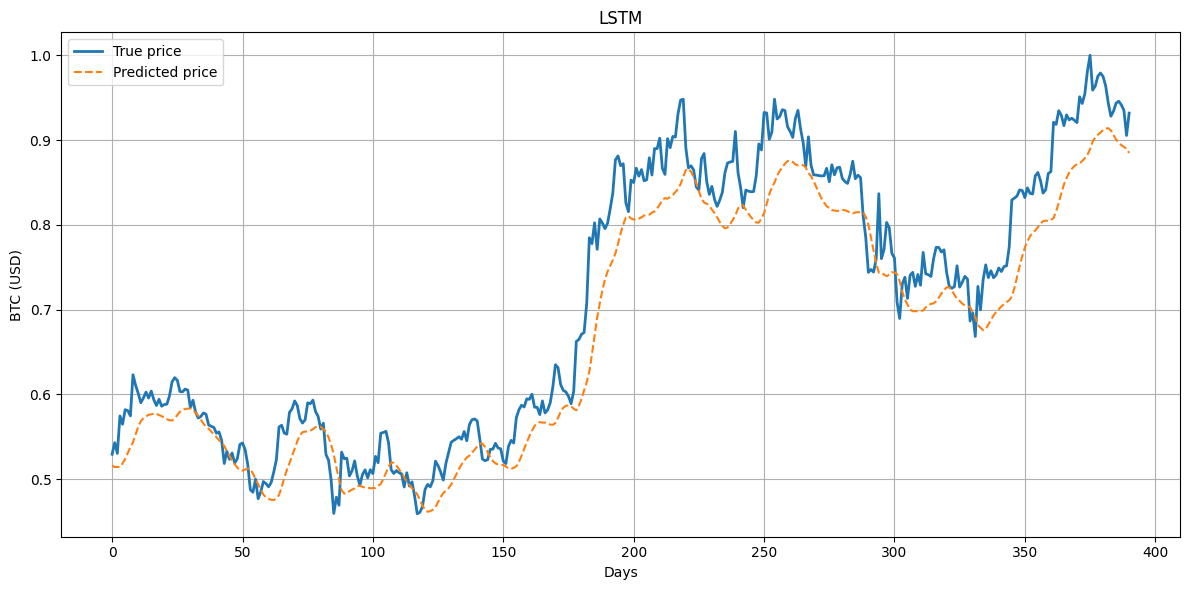

In [39]:
model, val_loader, _ = set_and_train("LSTM", hidden_size=64, num_layers=2, epochs=20, lr=1e-3, history_days=30)
plot_one_day_prediction(model, val_loader)

In [40]:
def plot_forecast(model, data, HISTORY_DAYS=30, FUTURE_DAYS=30, start_index=None):
    model.eval()

    if start_index is None:
        start_index = len(data) - FUTURE_DAYS - HISTORY_DAYS

    assert start_index >= HISTORY_DAYS, "Not enough history before start_index"
    assert start_index + FUTURE_DAYS <= len(data), "Not enough future data after start_index"

    history_scaled = data[start_index - HISTORY_DAYS:start_index].reshape(-1)
    true_future_scaled = data[start_index:start_index + FUTURE_DAYS].reshape(-1)
    full_window = np.concatenate([history_scaled, true_future_scaled])

    recent_sequence = history_scaled.reshape(1, HISTORY_DAYS, 1)
    recent_sequence = torch.tensor(recent_sequence, dtype=torch.float32).to(device)

    predicted_scaled = []
    with torch.no_grad():
        for _ in range(FUTURE_DAYS):
            next_pred = model(recent_sequence)
            predicted_scaled.append(next_pred.item())
            next_input = next_pred.view(1, 1, 1)
            recent_sequence = torch.cat((recent_sequence[:, 1:, :], next_input), dim=1).to(device)

    plt.figure(figsize=(14, 6))
    plt.plot(range(HISTORY_DAYS + FUTURE_DAYS), full_window,
             label="True Close", color='blue', linewidth=2)
    plt.plot(range(HISTORY_DAYS, HISTORY_DAYS + FUTURE_DAYS), predicted_scaled,
             label="Predicted Close", color='orange', linestyle='--', linewidth=2)

    plt.title(f"{HISTORY_DAYS}d History | {FUTURE_DAYS}d Prediction \nStart Index in Data: {start_index}")
    plt.xlabel("Day index")
    plt.ylabel("BTC")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

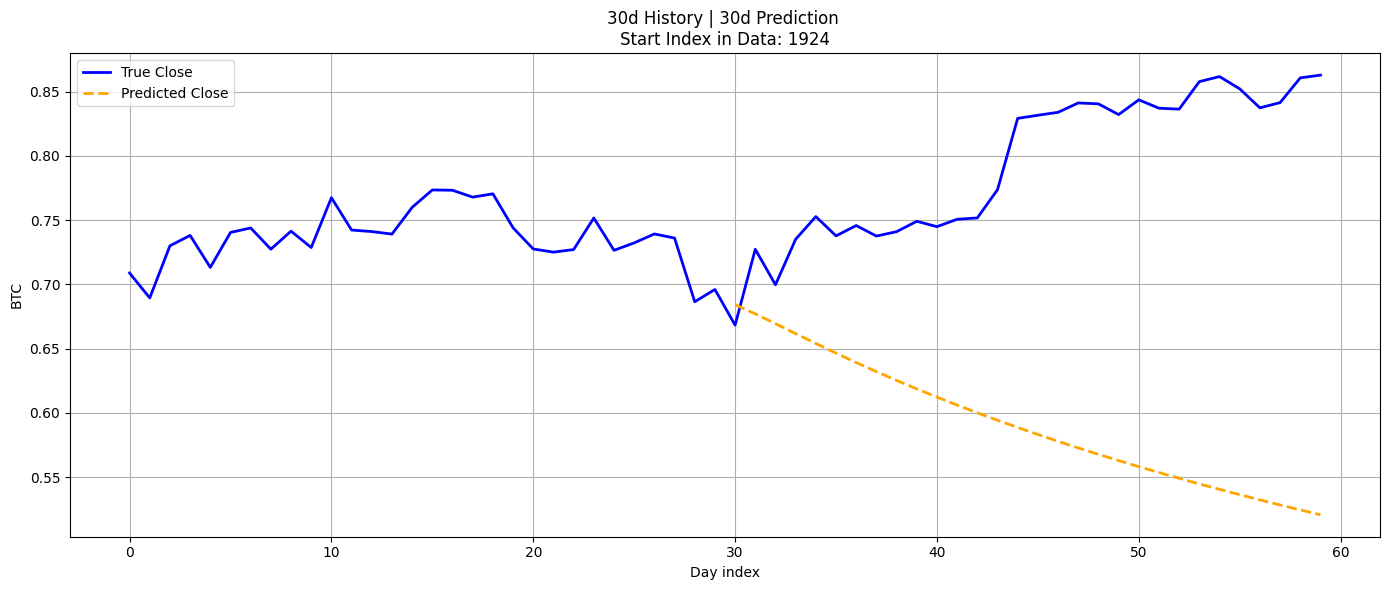

In [41]:
model, _, _ = set_and_train("LSTM", hidden_size=64, num_layers=2, epochs=20, lr=1e-3, history_days=30)
plot_forecast(model, scaled_data, HISTORY_DAYS=30, FUTURE_DAYS=30)

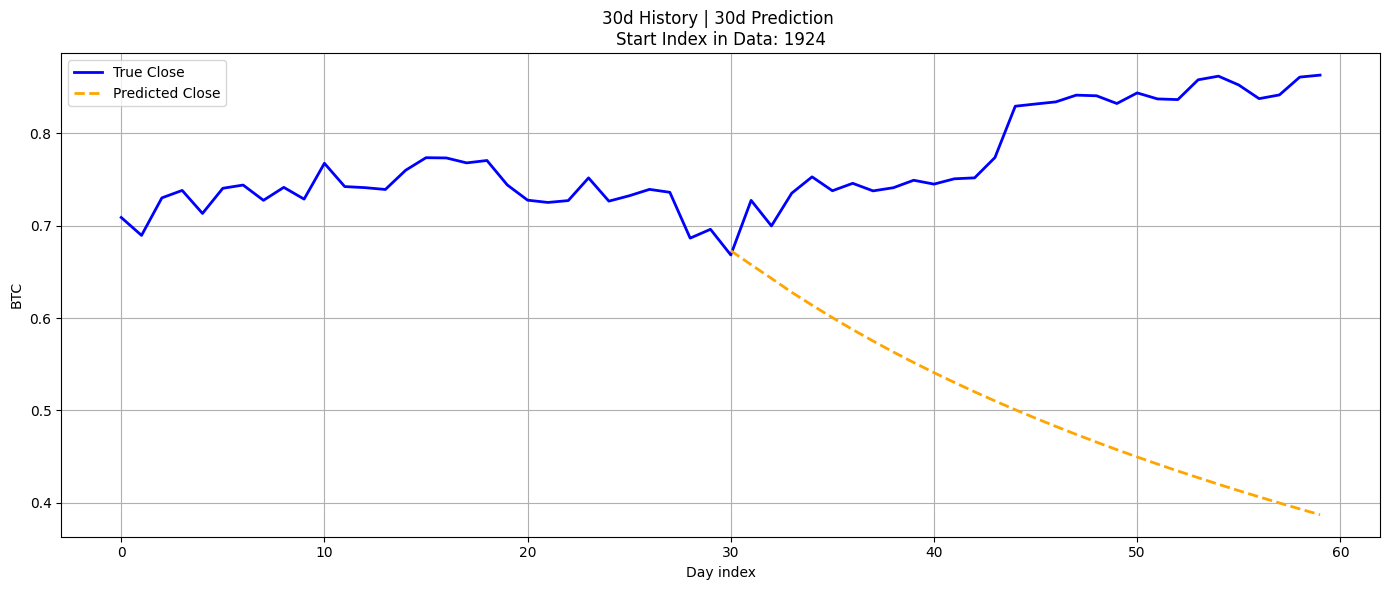

In [42]:
model, _, _ = set_and_train("RNN", hidden_size=64, num_layers=2, epochs=20, lr=1e-3, history_days=30)
plot_forecast(model, scaled_data, HISTORY_DAYS=30, FUTURE_DAYS=30)

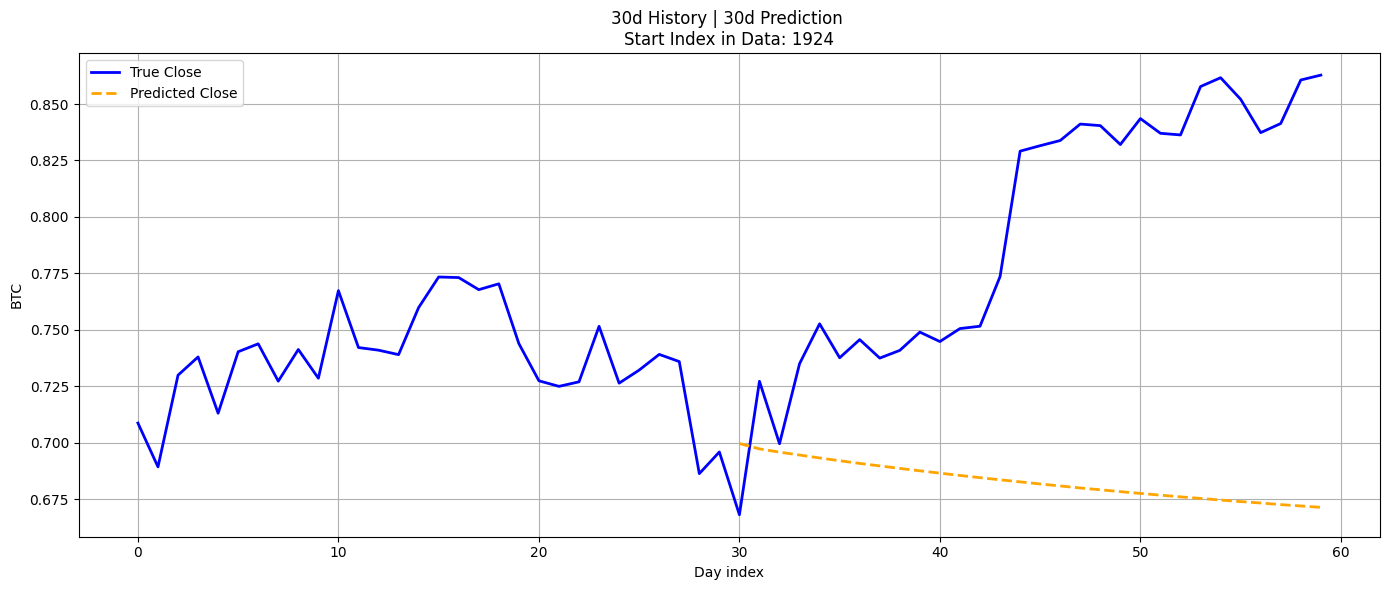

In [43]:
model, _, _ = set_and_train("GRU", hidden_size=64, num_layers=2, epochs=20, lr=1e-3, history_days=30)
plot_forecast(model, scaled_data, HISTORY_DAYS=30, FUTURE_DAYS=30)